# Assignment 2: Sampling
## Exercises week 3
This notebook contains approaches to solve the theoretical and practical (programming) exercises. There are often multiple correct approaches to solve the stated exercises.

Please reach out to the TA-team if you find mistakes in these here solution proposals.


### Bishop 11.3)
Given a random variable $z\sim U[0,1]$ find a transformation $y=f(z)$ s.t. $y$ has a Cauchy distribution given by (11.8).:

Let $p(y)=\frac{1}{\pi}\frac{1}{1+y^2}$ we require that $p(y)=p(z)\left|\frac{dz}{dy} \right| $.
Using $\int\frac{1}{1+t^2}dt=\arctan(t)+C$ and the fact that $\lim_{t \to -\infty}\arctan(t) =-\frac{\pi}{2}$, we obtain
\begin{align*}
z=h(x)&=\frac{1}{\pi}\int_{-\infty}^{y}\frac{1}{1+t^2}dt \\
%&=\frac{1}{\pi}\int_{arctan(-\infty)}^{arctan(y)}\frac{1}{1+t^2}dt \quad &\text{[by substitution]} \\
&= \frac{1}{\pi} \left[\arctan(t) \right]_{-\infty}^y \\
& =\frac{1}{\pi}  \left(\arctan(y) -\lim_{t \to -\infty}\arctan(t) \right)\\
%&=\frac{1}{\pi}\int_{-\frac{\pi}{2}}^{arctan(y)} 1 dt
& = \frac{1}{\pi}arctan(y)+\frac{1}{2} = z,
\end{align*}
We solve for $y$:
$y=tan((z-\frac{1}{2})\pi)$.

### Programming exercise, week 1)
Given is density $p(x)=\exp(\frac{-x^2}{2})(\sin(x)^2+3\cos(x)^2\sin(7x)^2+1)$ for $x\in[-3, 3]$.
Sample from this distribution to compute $\mathbb{E}[x^2]$.

#### 1) Rejection sampling uniform proposal

Text(0.5, 1.0, 'Unnormalized density $p(x)$')

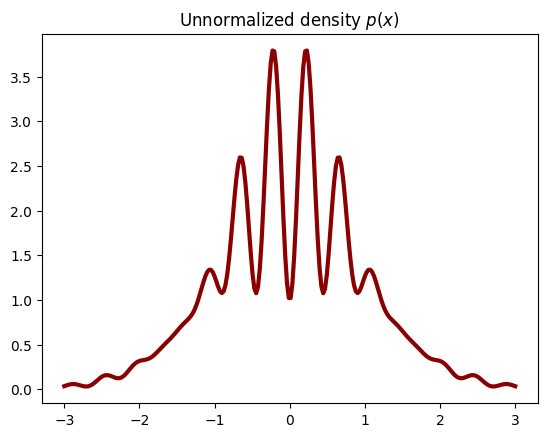

In [1]:
# import what you need
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous
from scipy.stats import uniform
from scipy.stats import norm

SEED=5122024 # lets be replicable here

np.random.seed(SEED)

# given density
def p(x): 
    return np.exp(-x**2/2)*(np.sin(x)**2 + 3*np.cos(x)**2 * np.sin(7*x)**2 + 1)

xx = np.linspace(-3, 3, 250)

plt.plot(xx, p(xx), lw=3, c="darkred")
plt.title(r"Unnormalized density $p(x)$")

In [2]:
# explore critical points by sampling
n_samples = 500

max_p_val = max(map(p, uniform.rvs(size=n_samples, loc=-2, scale=2)))

print(f"Sampled max observation: {np.round(max_p_val,3)}")

Sampled max observation: 3.809


In [3]:
"""
Here we define rejection sampling in general,
Such that we can exchange proposal distributions, if we use the scipy.stats distributions API.
"""

def rejection_sampling(sample_n: int, proposal_d: rv_continuous, k: float, target_p: Callable=p, seed: int=SEED, loc: float=0, scale: float=1) -> np.ndarray:
    print(f"RS with {proposal_d.__class__.__name__} proposals, k={np.round(k,3)} ...")
    zs = proposal_d.rvs(size=sample_n, random_state=seed, loc=loc, scale=scale)
    us = np.random.uniform(0, 1, size=sample_n) # NOTE: one can apply k and pdf to u interval
    accepted_samples = []
    for u, z in zip(us, zs): # NOTE: here are more efficient implementations possible than the one presented
        kqz = (k * proposal_d.pdf(z, loc=loc, scale=scale))
        if u <= (target_p(z) / kqz):
            accepted_samples.append(z)
    accepted_samples = np.array(accepted_samples)[np.isfinite(accepted_samples)]
    print(f"accepted samples n={len(accepted_samples)}")
    return accepted_samples

In [4]:
# determine constant for envelope
k_uniform = 3.99 * 6 # envelope size x length of interval
print(f"k={np.round(k_uniform, 2)}")

k=23.94


In [5]:
# determine M
q = uniform

u_samples = rejection_sampling(sample_n=n_samples, proposal_d=q, k=k_uniform, loc=-3, scale=3)

print(f"E[xˆ2]={np.round(np.mean(u_samples**2), 3)}")

RS with uniform_gen proposals, k=23.94 ...
accepted samples n=63
E[xˆ2]=0.748


#### 2) Rejection sampling Gaussian proposal

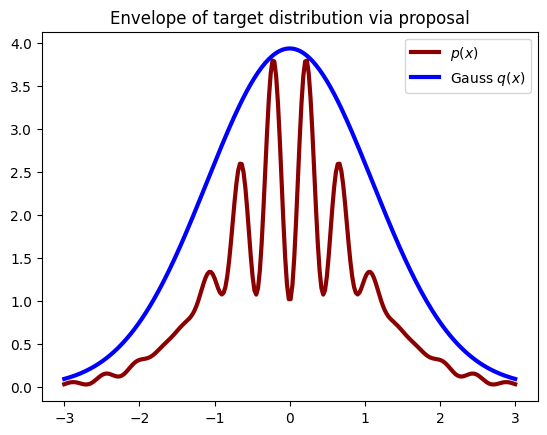

In [6]:
eps = 0.125
gauss_pdf_val = norm.pdf(0, scale=1.1) # compute PDF center value
k_normal = (max_p_val+eps) / gauss_pdf_val

plt.plot(xx, p(xx), lw=3, c="darkred", label=r"$p(x)$")
plt.plot(xx, norm.pdf(xx, scale=1.1)*k_normal, lw=3., c="blue", label=r"Gauss $q(x)$")
plt.title("Envelope of target distribution via proposal")
plt.legend()

In [7]:
print(f"Proposed constant (Gaussian) k={np.round(k_normal, 3)}")

Proposed constant (Gaussian) k=10.847


In [8]:
# run rejection sampling
norm_samples = rejection_sampling(sample_n=n_samples, proposal_d=norm, k=k_normal)

print(f"E[xˆ2]={np.round(np.mean(norm_samples**2), 4)}")

RS with norm_gen proposals, k=10.847 ...
accepted samples n=279
E[xˆ2]=0.8533


#### 3) Self-normalized IS

In [9]:
def normalized_IS(sample_n: int, proposal_d: object, target_p: Callable=p) -> np.ndarray:
    zs = proposal_d.rvs(size=sample_n)
    ws = np.array(list(map(target_p, zs))) / proposal_d.pdf(zs)
    weighted_sample = ws / np.sum(ws)
    f = lambda x: x[0]*x[1]**2
    mus = np.array(list(map(f, zip(weighted_sample, zs))))
    return mus

In [10]:
nis_vec = normalized_IS(sample_n=n_samples, proposal_d=norm)

# second moment
print(f"E[xˆ2]={np.round(np.sum(nis_vec), 3)}")

E[xˆ2]=0.961


#### Repeated sampling 
with sample sizes $n\in[10, 100, 1000]$, repeat with $N$ trials and compute mean and standard deviation of the estimator $\mathbb{E}[x^2]$.

In [11]:
# wrap functions for re-use:
def rs_uniform(n: int) -> np.ndarray:
    return rejection_sampling(sample_n=n, proposal_d=uniform, k=k_uniform, loc=-3, scale=3)

def rs_normal(n: int) -> np.ndarray:
    return rejection_sampling(sample_n=n, proposal_d=norm, k=k_normal)

def sn_is(n: int) -> np.ndarray:
    return normalized_IS(n, norm)

In [12]:
N = 10
sample_sizes = [10, 100, 1000]
s_range = range(len(sample_sizes))
sampling_functions = [rs_uniform, rs_normal, sn_is]

results = {s.__name__ : {
            "mu": [[] for _ in s_range], 
            "N": [[] for _ in s_range],
            }
        for s in sampling_functions
        }

for i, n in enumerate(sample_sizes):
    for k in range(N):
        for sampling_f in sampling_functions:
            sample_vec = sampling_f(n)
            quantity = np.mean(sample_vec**2) if not sampling_f.__name__ == "sn_is" else np.sum(sample_vec)
            results[sampling_f.__name__]["mu"][i].append(quantity)
            results[sampling_f.__name__]["N"][i].append(len(sample_vec))

RS with uniform_gen proposals, k=23.94 ...
accepted samples n=5
RS with norm_gen proposals, k=10.847 ...
accepted samples n=5
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=3
RS with norm_gen proposals, k=10.847 ...
accepted samples n=9
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=2
RS with norm_gen proposals, k=10.847 ...
accepted samples n=6
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=1
RS with norm_gen proposals, k=10.847 ...
accepted samples n=5
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=0
RS with norm_gen proposals, k=10.847 ...
accepted samples n=8
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=5
RS with norm_gen proposals, k=10.847 ...
accepted samples n=6
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=2
RS with norm_gen proposals, k=10.847 ...
accepted samples n=5
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=3
RS with norm_gen proposals, k=10.847 ...
accepted samp

/Users/rcml/pml/pml24/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rcml/pml/pml24/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


RS with uniform_gen proposals, k=23.94 ...
accepted samples n=117
RS with norm_gen proposals, k=10.847 ...
accepted samples n=546
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=115
RS with norm_gen proposals, k=10.847 ...
accepted samples n=537
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=130
RS with norm_gen proposals, k=10.847 ...
accepted samples n=520
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=107
RS with norm_gen proposals, k=10.847 ...
accepted samples n=530
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=129
RS with norm_gen proposals, k=10.847 ...
accepted samples n=535
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=100
RS with norm_gen proposals, k=10.847 ...
accepted samples n=541
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=134
RS with norm_gen proposals, k=10.847 ...
accepted samples n=540
RS with uniform_gen proposals, k=23.94 ...
accepted samples n=113
RS with norm_gen proposa

/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_28342/1721056194.py:24: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0].set_xlim((0,1100))
/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_28342/1721056194.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim((0,1100))


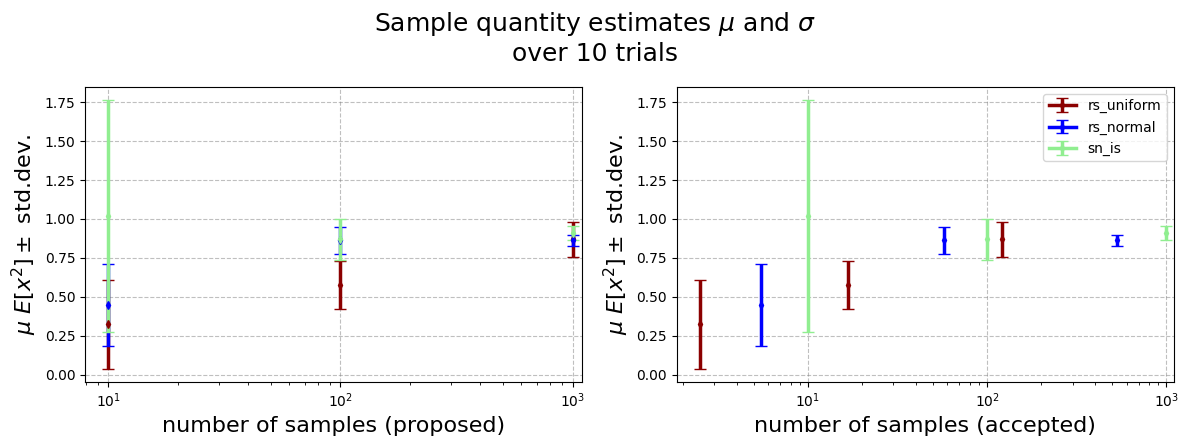

In [13]:
### visualize results in comparative overview

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))

for i, num_samples in enumerate(sample_sizes):
    for sampling_f, c in zip(sampling_functions, ["darkred", "blue", "lightgreen"]):
        f_name = sampling_f.__name__
        ax[0].errorbar(num_samples, np.nanmean(results.get(f_name).get("mu")[i]), yerr=np.nanstd(results.get(f_name).get("mu")[i]), 
                        c=c, lw=2.5, marker="d", ms=4., capsize=4., label=f"{f_name}" if i == 0 else "")
        ax[1].errorbar(np.nanmean(results.get(f_name).get("N")[i]), np.nanmean(results.get(f_name).get("mu")[i]), yerr=np.nanstd(results.get(f_name).get("mu")[i]), 
                        c=c, lw=2.5, marker="d", ms=4., capsize=4., label=f"{f_name}" if i == 0 else "")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_xlabel("number of samples (proposed)", fontsize=16)
ax[1].set_xlabel("number of samples (accepted)", fontsize=16)
ax[0].set_ylabel(r"$\mu$ $E[x^2]\pm$ std.dev.", fontsize=16)
ax[1].set_ylabel(r"$\mu$ $E[x^2]\pm$ std.dev.", fontsize=16)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[1].yaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[0].xaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[1].xaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[0].set_xlim((0,1100))
ax[1].set_xlim((0,1100))
plt.suptitle(r"Sample quantity estimates $\mu$ and $\sigma$"+f"\nover {N} trials", fontsize=18)
plt.legend()
plt.tight_layout()

### Pyro GMMs

In [14]:
import torch
import pyro
from pyro import poutine
import pyro.distributions as pdist

In [15]:
def gmm_pyro(n_samples: int) -> np.ndarray:
    with pyro.plate("data", n_samples): # plate object to declare independence
        cat = pyro.sample('cat', pdist.Categorical(torch.ones(2,) / 2.))
        x = pyro.sample("x", pdist.Normal(torch.tensor([[1, 1.], [3., 5.]])[cat], 1.).to_event(1))
        return x

samples = gmm_pyro(1000)
samples.shape

torch.Size([1000, 2])

In [16]:
# using trace
with poutine.trace() as tr:
    gmm_pyro(1000)

samples = tr.trace.nodes.get("x").get("value")
cats = tr.trace.nodes.get("cat").get("value")

Text(0.5, 1.0, 'GMM samples from Pyro')

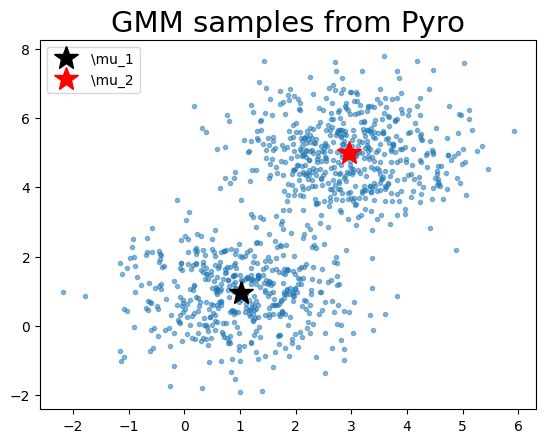

In [17]:
plt.scatter(samples[:, 0], samples[:, 1], marker=".", alpha=0.5)
plt.plot(samples[cats==0][:,0].mean(), samples[cats==0][:,1].mean(), "k*", ms=18., label=r"\mu_1")
plt.plot(samples[cats==1][:,0].mean(), samples[cats==1][:,1].mean(), "r*", ms=18., label=r"\mu_2")
plt.legend()
plt.title("GMM samples from Pyro", fontsize=21)

#### Advanced, optional: conditional densities
##### Simple: using torch distribution objects

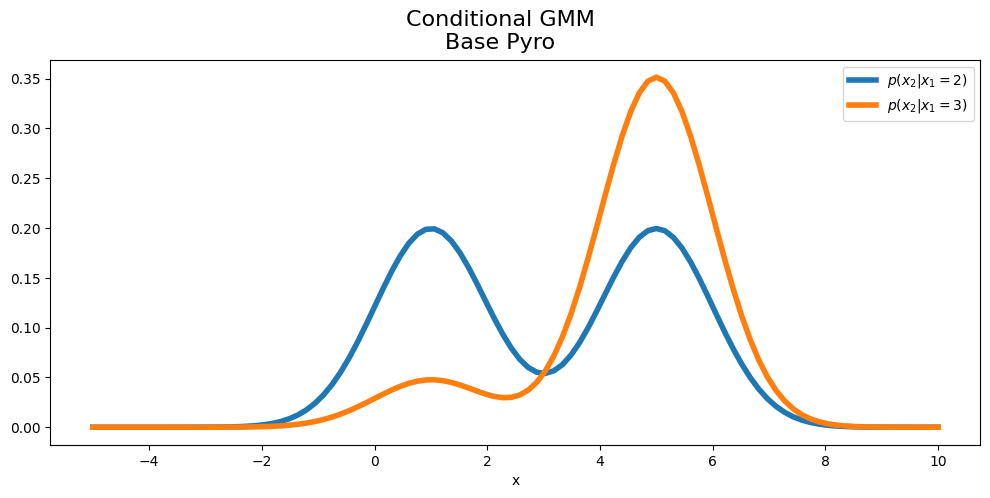

In [18]:
## AUTHOR: Han Tang
## DATE: 02-01-2024
## MINOR CHANGES: - combined two figures, figure formatting and annotations
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np

def p2_given_p1(x2, x1, pi=0.5):
    Xa_pdf = pyro.distributions.MultivariateNormal(loc=torch.tensor([1, 1]),
    covariance_matrix=torch.eye(2))
    Xb_pdf = pyro.distributions.MultivariateNormal(loc=torch.tensor([3, 5]), 
    covariance_matrix=torch.eye(2))

    Xa1_pdf = pyro.distributions.MultivariateNormal(loc=torch.tensor([1]), 
    covariance_matrix=torch.eye(1))
    Xb1_pdf = pyro.distributions.MultivariateNormal(loc=torch.tensor([3]), 
    covariance_matrix=torch.eye(1))

    p1_x1 = pi*torch.exp(Xa1_pdf.log_prob(torch.tensor([x1]))) + (1-
    pi)*torch.exp(Xb1_pdf.log_prob(torch.tensor([x1])))
    out = (pi*torch.exp(Xa_pdf.log_prob(torch.tensor([x1, x2]))) + (1-
    pi)*torch.exp(Xb_pdf.log_prob(torch.tensor([x1, x2])))) / p1_x1
    return out


x2 = torch.linspace(-5, 10, 100)
p_x2_given_x1_2 = [p2_given_p1(x2_i, 2) for x2_i in x2]
x2_and_p2_2 = np.transpose(np.stack([x2, p_x2_given_x1_2]))

x2 = torch.linspace(-5, 10, 100)
p_x2_given_x1_3 = [p2_given_p1(x2_i, 3) for x2_i in x2]
x2_and_p2_3 = np.transpose(np.stack([x2, p_x2_given_x1_3]))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
ax.plot(x2_and_p2_2[:, 0], x2_and_p2_2[:, 1], lw=4., label=r"$p(x_2|x_1=2)$")
ax.plot(x2_and_p2_3[:, 0], x2_and_p2_3[:, 1], lw=4., label=r"$p(x_2|x_1=3)$")
ax.set_xlabel("x")
plt.suptitle("Conditional GMM\nBase Pyro", fontsize=16)
plt.legend()
plt.show()

##### Advanced: using Pyro sampling backend

In [19]:
def conditional_gmm_model(x1: float, x2:float=0, n_samples=500) -> poutine.Trace:
    """
    Provide the x1 value of MVN -> becomes data input to GMM model, with which samples are condition
    Make x2 an input parameter to query for likelihood across range later.
    Returns poutine trace object.
    We try to use effect handlers maximally here.
    Recommended reading: https://docs.pyro.ai/en/stable/poutine.html 
    """
    # NOTE: this is only a nested model because we want to pass number of samples directly
    def gmm_joint_model(n_samples=n_samples):
        """
        Basic GMM model in Pyro with a few more explanatory lines.
        Samples n_samples from mixture of Gaussians.
        """
        # the equal weighting of categories
        pis = torch.ones(2,)/2.
        # our MVN means
        means = torch.tensor([[1., 1.], [3., 5.]])
        # constraints here are optional
        weights = pyro.param("weights", pis, constraint=pdist.constraints.simplex)

        # Mixture assignment for each data point
        with pyro.plate("data", n_samples):
            # sample which Normal to draw from
            assignment = pyro.sample("assignment", pdist.Categorical(weights), 
                            infer={"enumerate": "parallel"})
            # NOTE (trick 1): we have to consider x1 and x2 individually to compute likelihoods later
            pyro.sample("x1", pdist.Normal(torch.tensor([1., 3.])[assignment], 1.))
            pyro.sample("x2", pdist.Normal(torch.tensor([1., 5.])[assignment], 1.)) # NOTE: conditioning can also be done here with obs=... parameter

    conditioned_model = poutine.condition(gmm_joint_model, data={"x1": torch.tensor([x1]), "x2": torch.tensor([x2])})
    # trace required to compute log probability later
    trace = poutine.trace(conditioned_model).get_trace()
    return trace

In [20]:
conditional_values = [2., 3.]
x2_space=torch.linspace(-5, 10, 200)
gmm_n_samples=100 # more samples higher resolution

result_vals = []
for x1 in conditional_values:
    likelihood_vals = []
    for x2 in x2_space:
        trace_model = conditional_gmm_model(x1, x2, n_samples=gmm_n_samples)
        trace_model.compute_log_prob() # required to compute log_prob explicitly
        # obtain log-likelihoods from all named nodes
        x1_logp = trace_model.nodes["x1"]["log_prob"]
        x2_logp = trace_model.nodes["x2"]["log_prob"]
        cat_logp = trace_model.nodes["assignment"]["log_prob"]
        ll_val = ((x1_logp + x2_logp + cat_logp).logsumexp(0) - (x1_logp + cat_logp).logsumexp(0)) # conditional likelihood in log
        likelihood_vals.append(np.atleast_1d(ll_val.exp().detach().numpy())) # convert log-likelihoods to likelihoods
    result_vals.append(np.concatenate(likelihood_vals))

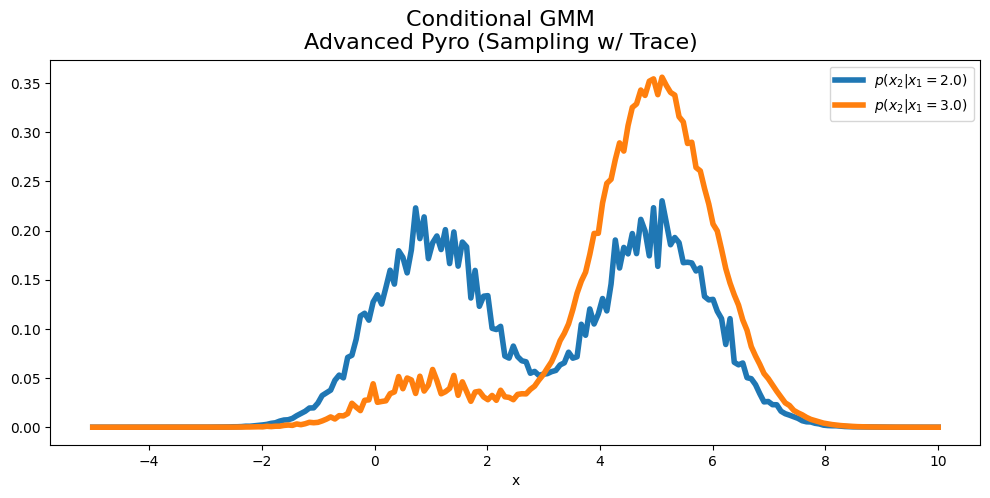

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
for x2, sampled_vals in zip(conditional_values, result_vals):
    ax.plot(x2_space, sampled_vals, lw=4., label=r"$p(x_2|x_1=$"+str(x2)+")")
ax.set_xlabel("x")
plt.suptitle("Conditional GMM\nAdvanced Pyro (Sampling w/ Trace)", fontsize=16)
plt.legend()
plt.show()

## Exercises week 4
### Programming exercise advanced sampling

#### 1) NUTS

In [22]:
# load more Pyro machinery
import pyro
import torch
import pyro.distributions as pdist
from torch.distributions import constraints

# infer objects required for task:
from pyro.infer.mcmc import NUTS
from pyro.infer.svi import SVI
from pyro.infer.mcmc import MCMC

import arviz as az
import matplotlib.pyplot as plt

pyro.clear_param_store()

In [23]:
class Density(pdist.TorchDistribution):
    # required to define the support property
    support = constraints.interval(torch.tensor(-3.), torch.tensor(3.))
    # set as constraints w.r.t. start
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.), validate_args=None):
        self.start = start
        batch_shape = start.shape
        super().__init__(batch_shape, (), validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        return self.start

    def log_prob(self, x):
        # apply log to proposal distribution
        return -x**2./2. + torch.log( ((torch.sin(x))**2. + 3.*(torch.cos(x))**2.*(torch.sin(7.*x))**2. + 1.) )

In [24]:
def model():
    x = pyro.sample("x", Density())

In [25]:
# compute second moment quantity
nuts_kernel = pyro.infer.NUTS(model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, warmup_steps=1000, num_samples=n_samples*5)
mcmc.run()

samples = mcmc.get_samples()["x"]

print(f"E[x^2]={torch.mean(samples**2).item()}")

Sample: 100%|██████████| 3500/3500 [00:09, 365.88it/s, step size=1.65e-01, acc. prob=0.894]

E[x^2]=0.8909322023391724


arviz - WARNING - Shape validation failed: input_shape: (1, 2500), minimum_shape: (chains=2, draws=4)


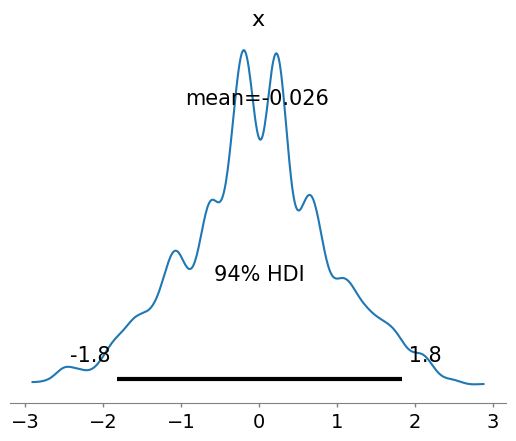

In [26]:

sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)

az.plot_posterior(sample_data)
plt.show()

#### 2) Repeated sampling
given different sample sizes and a number of trials.

In [27]:
# 4.) repeat sampling with different sizes, compute quantities from different trials:
trials = 10
sample_sizes = [10, 100, 1000]
s_range = range(len(sample_sizes))

results["mcmc"] = {
            "mu": [[] for _ in s_range], 
            "N": [[] for _ in s_range]
            }

# add MCMC to existing results
for i,n in enumerate(sample_sizes):
    for k in range(trials):
        nuts_kernel = NUTS(model=model, jit_compile=True)
        mcmc = MCMC(nuts_kernel, num_samples=n, num_chains=1, warmup_steps=0)
        mcmc.run()
        samples = mcmc.get_samples()

        print(mcmc.summary())

        second_moment_s = torch.mean(samples.get('x')**2)
        results["mcmc"]["mu"][i].append(second_moment_s)
        results["mcmc"]["N"][i].append(len(samples.get("x")))

Sample: 100%|██████████| 10/10 [00:00, 159.99it/s, step size=2.50e-01, acc. prob=0.707]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.18      0.35     -1.38     -1.54     -0.56      7.01      1.01

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 179.87it/s, step size=5.00e-01, acc. prob=0.366]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.66      0.77      0.17      0.11      1.95      3.24      1.57

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 139.80it/s, step size=6.25e-02, acc. prob=0.947]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.56      0.45     -0.34     -1.12     -0.02      7.52      1.54

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 194.56it/s, step size=1.25e-01, acc. prob=0.839]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.19      0.09      0.13      0.08      0.34      6.88      1.14

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 193.88it/s, step size=2.50e-01, acc. prob=0.871]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      1.56      0.36      1.69      0.87      2.00      5.37      0.90

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 202.31it/s, step size=5.00e-01, acc. prob=0.250]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.37      0.37     -0.24     -1.22      0.18      6.69      1.40

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 184.54it/s, step size=2.50e-01, acc. prob=0.711]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.72      0.43     -0.74     -1.41     -0.19      6.90      0.94

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 210.00it/s, step size=2.00e+00, acc. prob=0.058]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.43      0.00     -1.43     -1.43     -1.43       nan       nan

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 178.90it/s, step size=2.50e-01, acc. prob=0.673]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.46      0.49     -1.62     -2.26     -0.59      3.53      1.50

Number of divergences: 0
None


Sample: 100%|██████████| 10/10 [00:00, 204.28it/s, step size=2.00e+00, acc. prob=0.100]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.49      2.16      1.81     -2.01      2.38      4.61      0.90

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 752.99it/s, step size=2.00e+00, acc. prob=0.041]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.36      1.58     -2.18     -2.35      1.64      5.84      1.31

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 724.21it/s, step size=2.00e+00, acc. prob=0.102]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.53      1.54     -1.31     -2.02      1.76     20.23      1.07

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 696.93it/s, step size=2.00e+00, acc. prob=0.041]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.09      1.02     -0.19     -1.80      1.38     13.55      1.16

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 666.29it/s, step size=2.00e+00, acc. prob=0.001]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.47      0.00     -0.47     -0.47     -0.47       nan       nan

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 456.10it/s, step size=2.50e-01, acc. prob=0.607]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.04      1.00     -0.17     -1.81      1.50      6.74      1.29

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 807.09it/s, step size=2.00e+00, acc. prob=0.011]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -1.20      0.00     -1.20     -1.20     -1.20      0.50       nan

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 742.49it/s, step size=2.00e+00, acc. prob=0.099]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.51      1.25     -1.05     -2.46      1.42     14.16      1.07

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 324.62it/s, step size=1.25e-01, acc. prob=0.840]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.50      1.25     -0.35     -2.78      1.17     34.20      0.99

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 416.08it/s, step size=2.50e-01, acc. prob=0.572]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.52      1.00      0.43     -0.68      2.87     10.64      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 100/100 [00:00, 617.27it/s, step size=2.00e+00, acc. prob=0.152]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.12      1.60      0.21     -1.53      2.83     14.05      1.18

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 772.63it/s, step size=5.00e-01, acc. prob=0.377]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.08      0.95     -0.19     -1.63      1.44     87.27      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:03, 283.20it/s, step size=6.25e-02, acc. prob=0.964]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.07      0.93     -0.08     -1.48      1.74    118.44      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:02, 425.48it/s, step size=1.25e-01, acc. prob=0.817]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.21      1.03     -0.19     -1.74      1.52     80.67      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 571.43it/s, step size=2.50e-01, acc. prob=0.604]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.01      1.02     -0.03     -1.70      1.58     57.18      1.05

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 937.05it/s, step size=2.00e+00, acc. prob=0.061]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.25      1.12      0.46     -1.51      1.57     80.05      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 819.41it/s, step size=5.00e-01, acc. prob=0.414]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.13      1.10     -0.18     -1.79      1.91     71.38      1.01

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:00, 1008.53it/s, step size=2.00e+00, acc. prob=0.054]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.30      1.43     -0.88     -2.22      2.20     39.86      1.01

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 970.32it/s, step size=2.00e+00, acc. prob=0.071]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.05      1.20     -0.24     -1.71      1.80    149.25      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:01, 705.46it/s, step size=5.00e-01, acc. prob=0.388]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.00      0.95     -0.16     -1.32      1.75     60.03      1.00

Number of divergences: 0
None


Sample: 100%|██████████| 1000/1000 [00:00, 1038.74it/s, step size=2.00e+00, acc. prob=0.030]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.08      0.96     -0.18     -1.74      1.50     74.28      1.01

Number of divergences: 0
None


/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_28342/1295673615.py:30: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0].set_xlim((0,1100))
/var/folders/7n/r4gz04v155x34_3hgrpy2t900000gn/T/ipykernel_28342/1295673615.py:31: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim((0,1100))


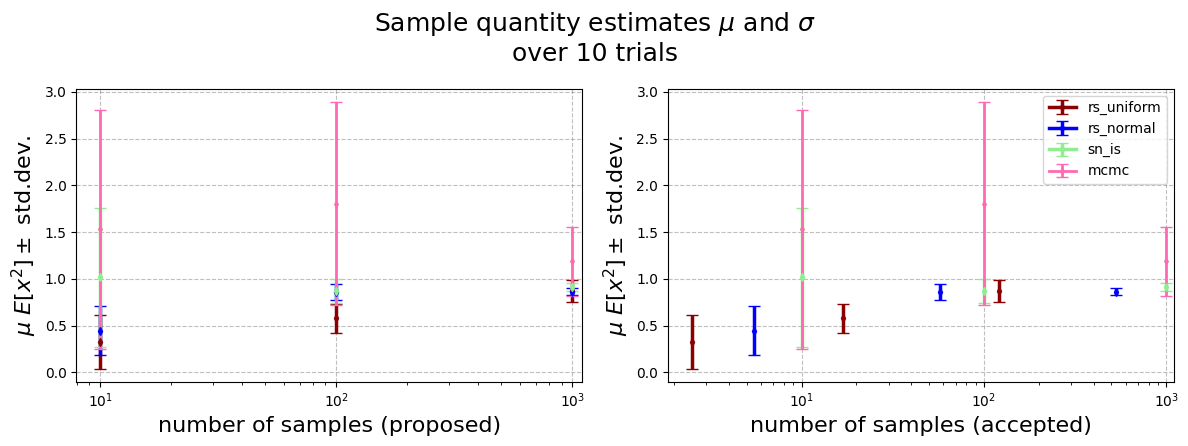

In [28]:
"""
Visualize Pyro results
"""

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4.5))

for i, num_samples in enumerate(sample_sizes):
    for sampling_f, c in zip(sampling_functions, ["darkred", "blue", "lightgreen"]):
        f_name = sampling_f.__name__
        ax[0].errorbar(num_samples, np.nanmean(results.get(f_name).get("mu")[i]), yerr=np.nanstd(results.get(f_name).get("mu")[i]), 
                        c=c, lw=2.5, marker="d", ms=4., capsize=4., label=f"{f_name}" if i == 0 else "")
        ax[1].errorbar(np.nanmean(results.get(f_name).get("N")[i]), np.nanmean(results.get(f_name).get("mu")[i]), yerr=np.nanstd(results.get(f_name).get("mu")[i]), 
                        c=c, lw=2.5, marker="d", ms=4., capsize=4., label=f"{f_name}" if i == 0 else "")
    ax[0].errorbar(num_samples, np.mean(results.get("mcmc").get("mu")[i]), yerr=np.std(results.get("mcmc").get("mu")[i]),
                        c="hotpink", lw=2., marker="d", ms=3., capsize=4., label=f"mcmc" if i == 0 else "")
    ax[1].errorbar(np.mean(results.get("mcmc").get("N")[i]), np.mean(results.get("mcmc").get("mu")[i]), yerr=np.std(results.get("mcmc").get("mu")[i]),
                        c="hotpink", lw=2., marker="d", ms=3., capsize=4., label=f"mcmc" if i == 0 else "")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_xlabel("number of samples (proposed)", fontsize=16)
ax[1].set_xlabel("number of samples (accepted)", fontsize=16)
ax[0].set_ylabel(r"$\mu$ $E[x^2]\pm$ std.dev.", fontsize=16)
ax[1].set_ylabel(r"$\mu$ $E[x^2]\pm$ std.dev.", fontsize=16)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[0].yaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[1].yaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[0].xaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[1].xaxis.grid(color='gray', alpha=0.5, linestyle='dashed')
ax[0].set_xlim((0,1100))
ax[1].set_xlim((0,1100))
plt.suptitle(r"Sample quantity estimates $\mu$ and $\sigma$"+f"\nover {trials} trials", fontsize=18)
plt.legend()
plt.tight_layout()

### Pyro Pt. 2
#### The Iris SVI model

In [29]:
import numpy as np
import sklearn
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn

In [30]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
np.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

In [31]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

In [32]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


In [33]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXERCISE: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXERCISE: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            x=pyro.sample("x", pdist.Categorical(logits=logits), obs=y)

In [35]:
# Clear any previously used parameters

pyro.clear_param_store()
n=1500
n_chains=3
iris_data=None

# sequentially run chains, since backend mp_context is not working as expected. Parallel running broken for notebooks.
for _i in range(n_chains):
    # Instantiate the Model object
    iris_model=Model()

    iris_nuts_kernel = NUTS(model=iris_model, adapt_step_size=True, jit_compile=True)
    iris_mcmc = MCMC(iris_nuts_kernel, num_samples=n, num_chains=1, warmup_steps=300, mp_context=None) # NOTE: num_chains>1 expected, additional script used for that OOS for notebook
    iris_mcmc.run(x, y)
    if iris_data == None:
        iris_data = az.from_pyro(iris_mcmc)
    else:
        iris_data_i = az.from_pyro(iris_mcmc)
        iris_data = az.concat(iris_data, iris_data_i, dim="chain")


Warmup:   0%|          | 0/1800 [00:00, ?it/s]/Users/rcml/pml/pml24/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 1800/1800 [10:11,  2.94it/s, step size=8.66e-03, acc. prob=0.953]
/Users/rcml/pml/pml24/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
Warmup:   0%|          | 0/1800 [00:00, ?it/s]/Users/rcml/pml/pml24/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registere


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.07      1.04      0.09     -1.65      1.73    346.43      1.00
     b1[1]      0.00      1.04      0.01     -1.73      1.68    329.58      1.01
     b1[2]      0.12      1.08      0.12     -1.58      1.86    440.22      1.00
     b1[3]      0.02      1.07      0.04     -1.61      1.81    405.78      1.00
     b1[4]      0.04      1.05      0.04     -1.51      1.89    535.15      1.01
     b2[0]      0.05      0.92      0.04     -1.40      1.59   1544.67      1.00
     b2[1]      0.03      0.90      0.01     -1.31      1.56   1900.75      1.00
     b2[2]      0.00      0.94     -0.00     -1.39      1.60   1366.91      1.00
     b2[3]     -0.01      0.91     -0.03     -1.47      1.50   1767.89      1.00
     b2[4]      0.01      0.94     -0.02     -1.53      1.46   1779.77      1.00
     b3[0]      0.01      0.86     -0.00     -1.40      1.41   1182.69      1.00
     b3[1]     -0.20      0

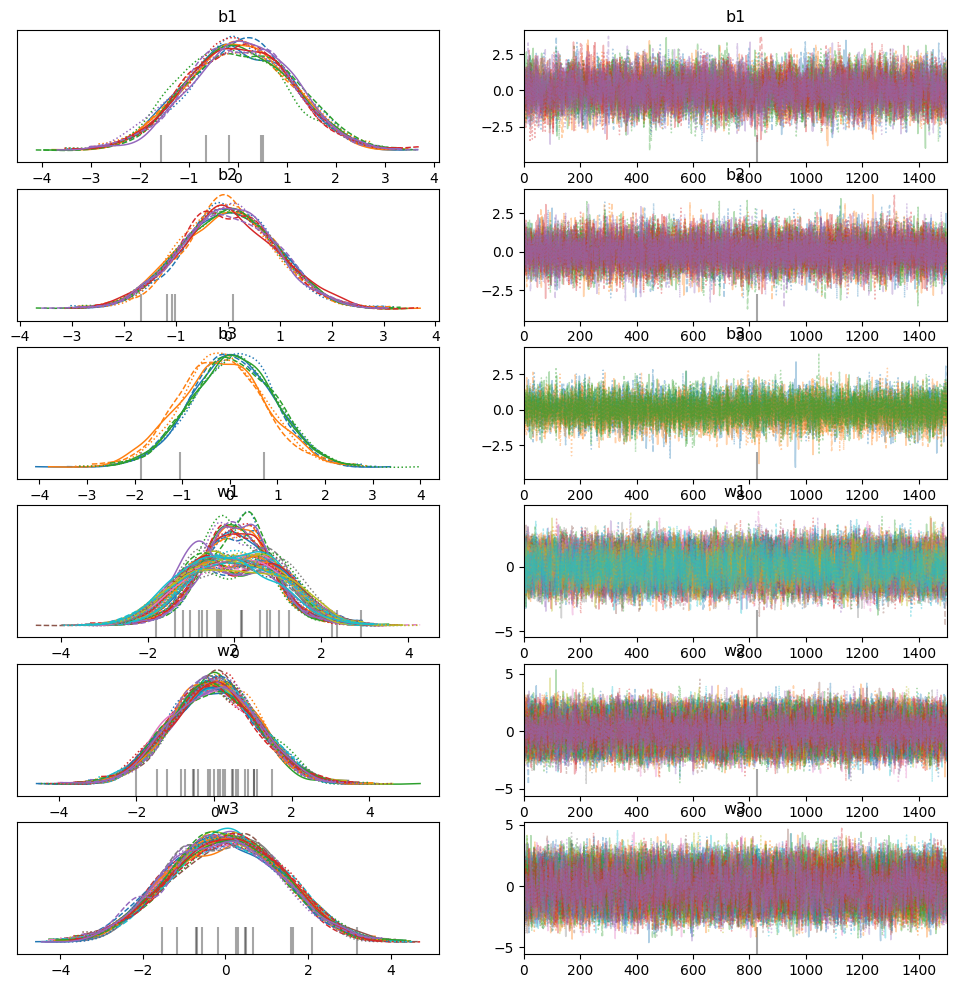

/Users/rcml/pml/pml24/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (73) in plot_posterior, generating only 40 plots
  warnings.warn(


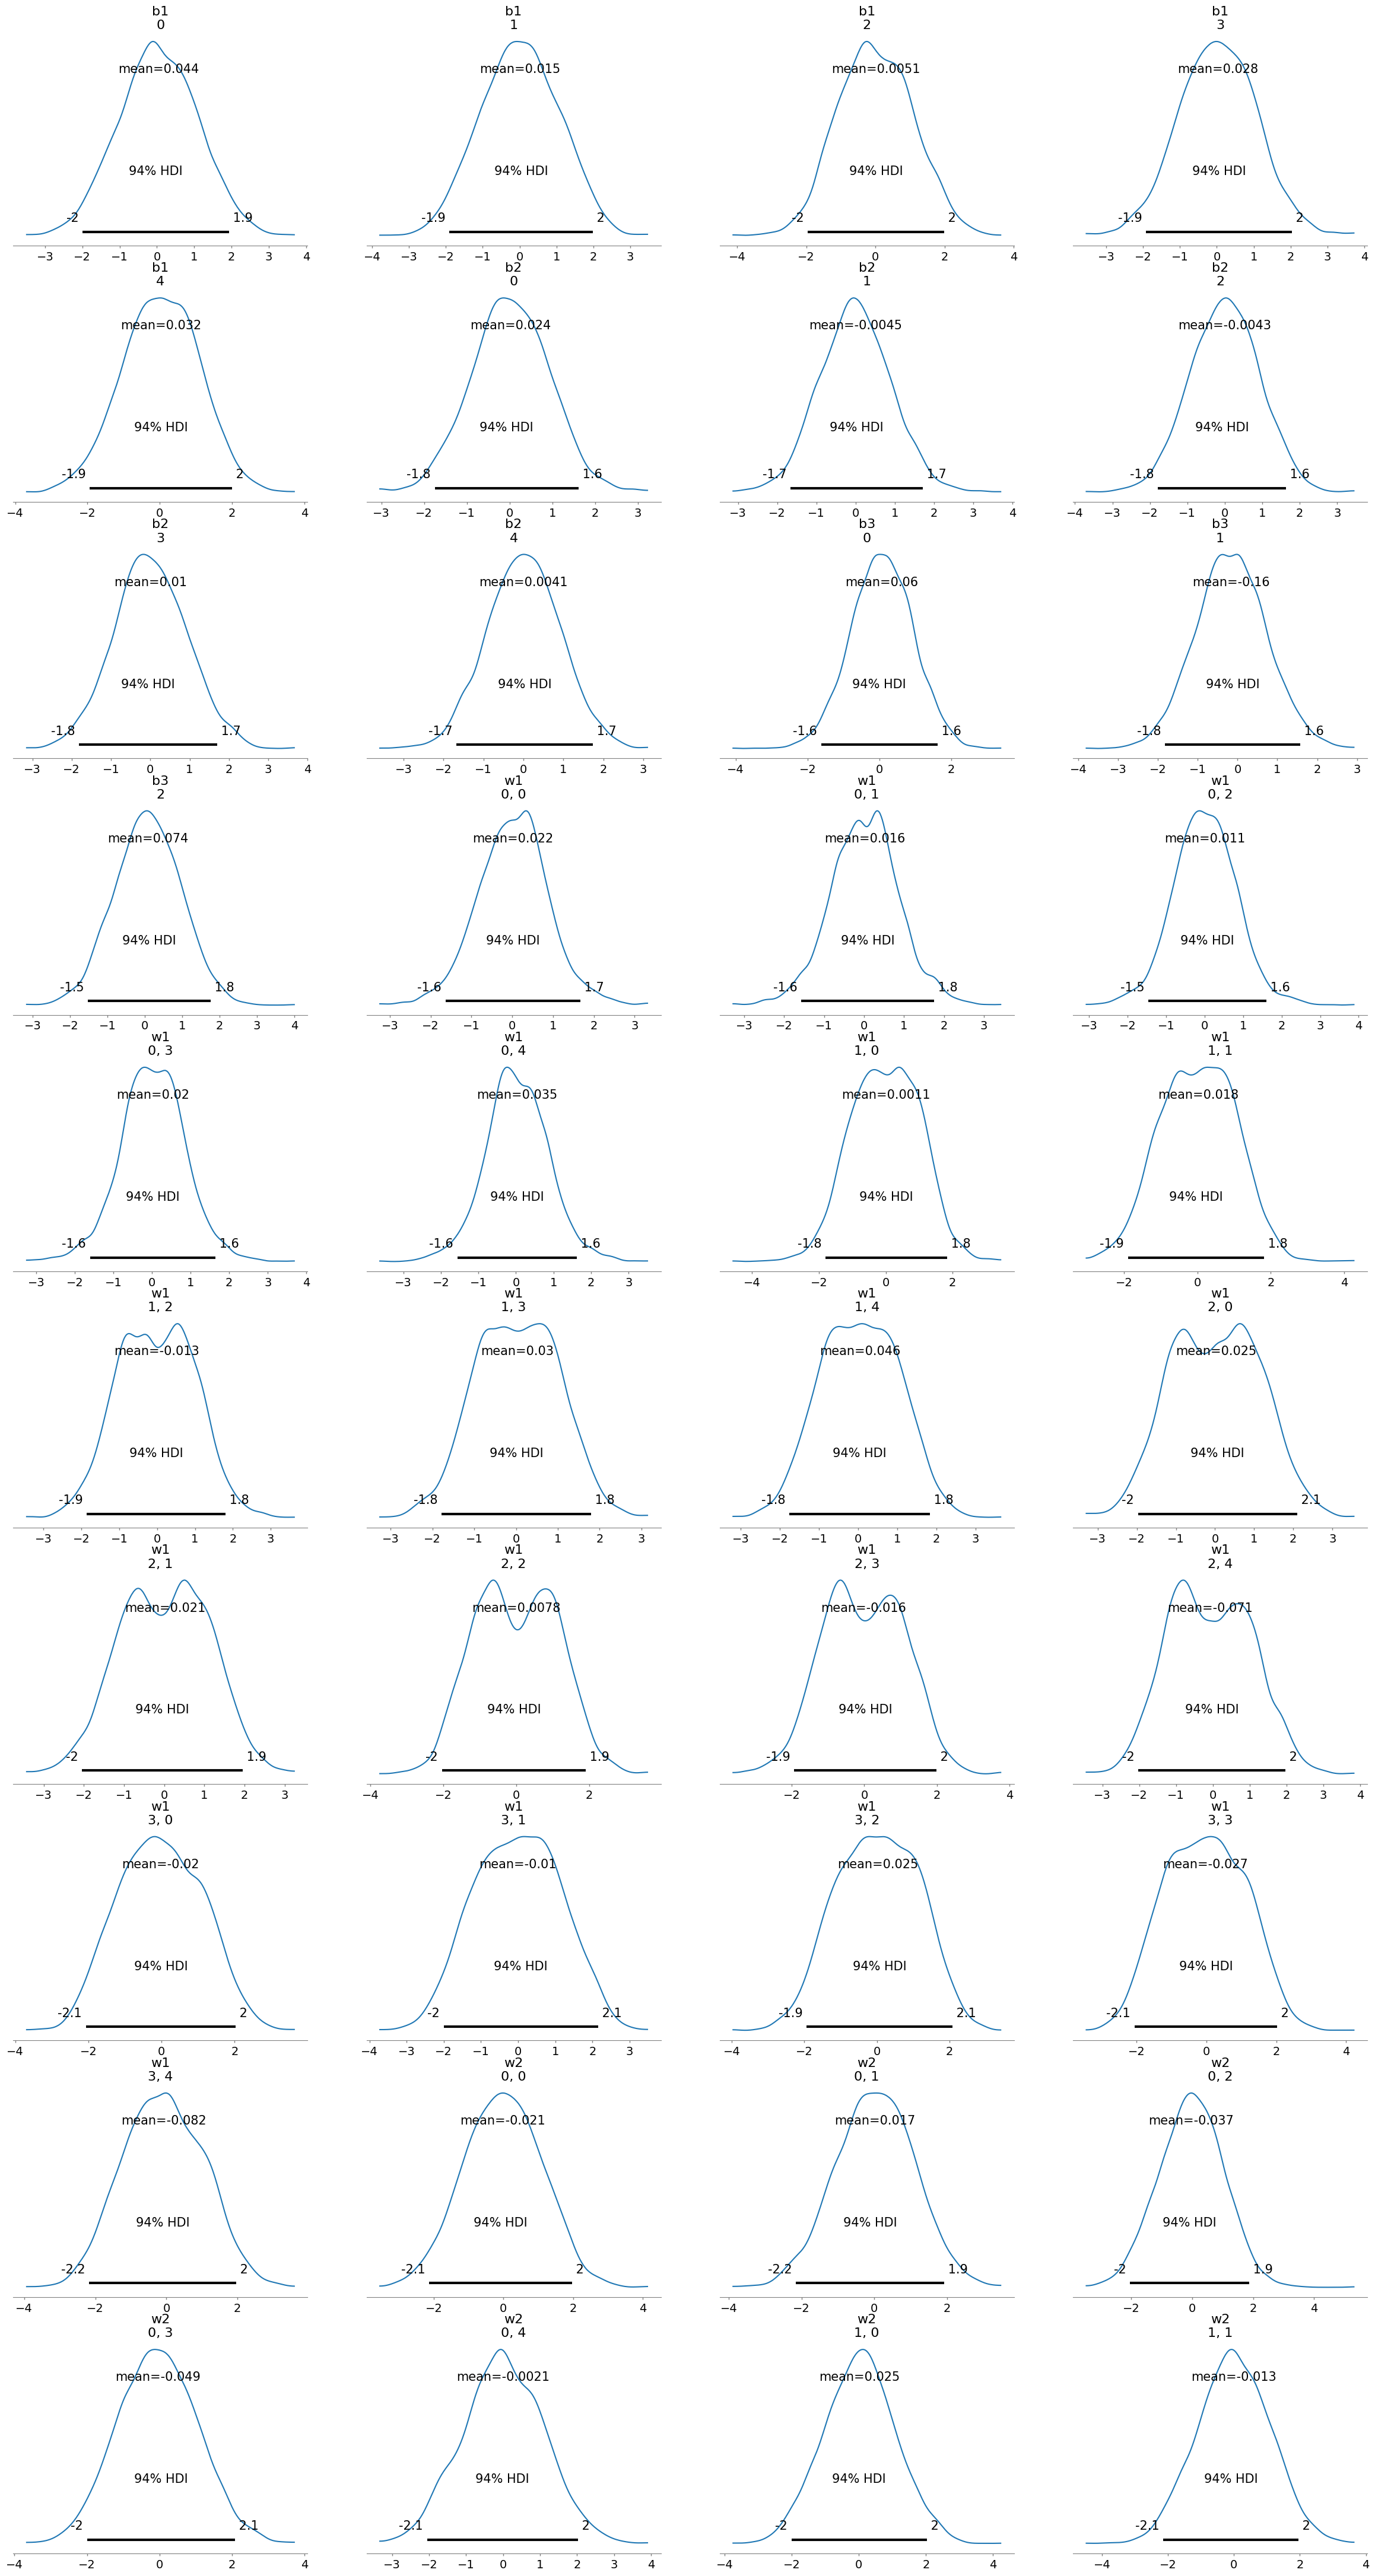


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.07      1.04      0.09     -1.65      1.73    346.43      1.00
     b1[1]      0.00      1.04      0.01     -1.73      1.68    329.58      1.01
     b1[2]      0.12      1.08      0.12     -1.58      1.86    440.22      1.00
     b1[3]      0.02      1.07      0.04     -1.61      1.81    405.78      1.00
     b1[4]      0.04      1.05      0.04     -1.51      1.89    535.15      1.01
     b2[0]      0.05      0.92      0.04     -1.40      1.59   1544.67      1.00
     b2[1]      0.03      0.90      0.01     -1.31      1.56   1900.75      1.00
     b2[2]      0.00      0.94     -0.00     -1.39      1.60   1366.91      1.00
     b2[3]     -0.01      0.91     -0.03     -1.47      1.50   1767.89      1.00
     b2[4]      0.01      0.94     -0.02     -1.53      1.46   1779.77      1.00
     b3[0]      0.01      0.86     -0.00     -1.40      1.41   1182.69      1.00
     b3[1]     -0.20      0

In [36]:
# inspect visually
print(iris_mcmc.summary())
az.plot_trace(iris_data)
plt.show()
az.plot_posterior(iris_data)
plt.show()
print(iris_mcmc.summary())

### Differences SVI, MCMC

#### 3.) Posterior Representation in Pyro.
SVI requires a model and a guide, training is minimizing the divergence between the two distributions which requires a loss (such as trace ELBO) and an Adam optimizer using gradients. We can obtain a posterior predictive from the guide. There is a chance that the posterior variance is not the true posterior variance (under-estimate).

MCMC samples with chains and from the sample aggregate we can recover the posterior predictive. We require a sampling object - referred to as kernel (ie NUTS, HMC). In the limit (given enough chains, warmup and samples) MCMC converges to the true posterior distribution. Per default zeroeth order.

#### 4.) Advantages and Disadvantages
SVI: deterministic optimization process, is memory- and time-efficient (amortization, can use gradients) .
MCMC: probabilistic computationally expensive sampling procedure, gives reliable estimates (in the limit), but at high computational costs.

The given problems are all manageable by MCMC. If Pyro MCMC too slow JIT compile, if that is still to slow build the same model in STAN and repeat.
However the correct response for 4) is probably that the Iris problem is too large for MCMC and should be approached with SVI, while the coin flip is small enough for MCMC.

## Programming GPs

In [37]:
import numpy as np
import scipy
from scipy import stats as ss
import matplotlib.pyplot as plt
import torch
import inspect
from matplotlib import colormaps 
cmap = 'plasma'

SEED=512024

In [38]:
### A)
def gauss_kernel(x: float, y: float, gamma: float=1.) -> float:
    return np.exp(-gamma*np.power((x-y), 2))

In [39]:
# points to evaluate
S = np.linspace(0, 1, 101)
print(S[:3])
# in 2D pair of values
XX = np.dstack(np.meshgrid(S, S)).reshape(-1, 2)

cov_matrix = np.array(list(map(lambda x: gauss_kernel(x[0], x[1]), XX))).reshape(S.shape[0], S.shape[0])
# NOTE: to be efficient, compute only upper triangle and mirror, since you should have a symmetric matrix
cov_matrix

[0.   0.01 0.02]


array([[1.        , 0.9999    , 0.99960008, ..., 0.38273976, 0.37527357,
        0.36787944],
       [0.9999    , 1.        , 0.9999    , ..., 0.39027643, 0.38273976,
        0.37527357],
       [0.99960008, 0.9999    , 1.        , ..., 0.39788192, 0.39027643,
        0.38273976],
       ...,
       [0.38273976, 0.39027643, 0.39788192, ..., 1.        , 0.9999    ,
        0.99960008],
       [0.37527357, 0.38273976, 0.39027643, ..., 0.9999    , 1.        ,
        0.9999    ],
       [0.36787944, 0.37527357, 0.38273976, ..., 0.99960008, 0.9999    ,
        1.        ]])

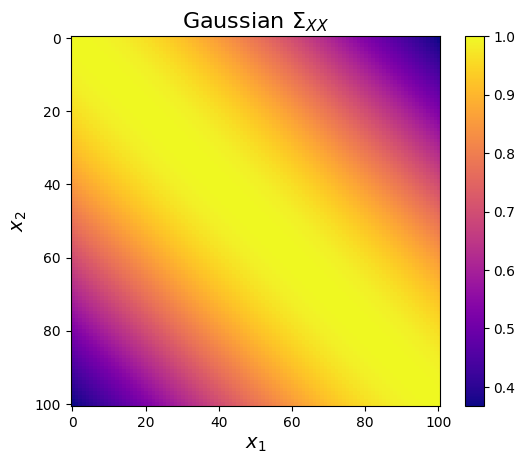

In [40]:
plt.imshow(cov_matrix, cmap=cmap)
plt.title(r"Gaussian $\Sigma_{XX}$", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.colorbar()
plt.show()

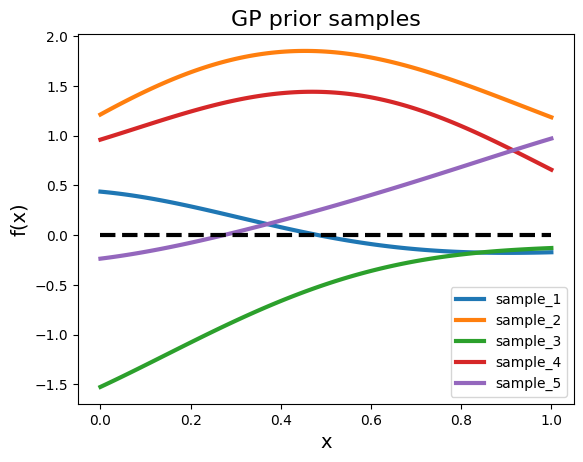

In [41]:
gp_prior_samples = ss.multivariate_normal.rvs(mean=np.zeros(S.shape[0]), cov=cov_matrix, size=5, random_state=SEED)

for i, sample in enumerate(gp_prior_samples):
    plt.plot(S, sample, lw=3., label=f"sample_{i+1}")
plt.hlines(0, S[0], S[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title("GP prior samples", fontsize=16)
plt.show()

In [42]:
### USE PROVIDED HINTS:
def ref_gaussian_kernel(X,Xprime, gamma=1):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

ref_cov = ref_gaussian_kernel(S[:, np.newaxis], S[:, np.newaxis])

# Assess if our implementation is correct:
np.testing.assert_almost_equal(cov_matrix, ref_cov) 

In [43]:
data = np.loadtxt("./co2_mm_mlo.csv", delimiter=",", dtype=float)

# IMPORT preprocessing from provided script:
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

In [44]:
0.001*np.eye(y.shape[0])+ref_gaussian_kernel(X[:, np.newaxis], X[:, np.newaxis])

array([[1.00100000e+00, 9.92801038e-01, 9.72431308e-01, ...,
        4.84434311e-42, 9.19823952e-43, 1.72500509e-43],
       [9.92801038e-01, 1.00100000e+00, 9.93265936e-01, ...,
        2.52463516e-41, 4.86327955e-42, 9.25269628e-43],
       [9.72431308e-01, 9.93265936e-01, 1.00100000e+00, ...,
        1.22906784e-40, 2.40082782e-41, 4.63177547e-42],
       ...,
       [4.84434311e-42, 2.52463516e-41, 1.22906784e-40, ...,
        1.00100000e+00, 9.92834754e-01, 9.71678539e-01],
       [9.19823952e-43, 4.86327955e-42, 2.40082782e-41, ...,
        9.92834754e-01, 1.00100000e+00, 9.92851582e-01],
       [1.72500509e-43, 9.25269628e-43, 4.63177547e-42, ...,
        9.71678539e-01, 9.92851582e-01, 1.00100000e+00]])

In [45]:
# use function definitions and fill in the blanks
# B)
def negLogLikelihood(params, kernel, S=X, y=y):
    noise_y = params[0]    
    eta = params[1:]
    sigma_y_I = noise_y*np.eye(y.shape[0])
    if "eta" in inspect.signature(kernel).parameters.keys(): # NOTE: this check is not strictly required
        K = kernel(S[:, np.newaxis], S[:, np.newaxis], eta=eta)
    else:
        K = kernel(S[:, np.newaxis], S[:, np.newaxis])
    n = y.shape[0]
    # using lecture notes 6.2
    observed_fit = y.T@scipy.linalg.inv(sigma_y_I+K)@y
    model_complexity = np.log(np.linalg.det(sigma_y_I+K))
    print(f"data fit={np.round(observed_fit,2)}")
    print(f"model complexity={np.round(model_complexity,2)}")
    # print(f"reg. const.={np.round(n/2*np.log(np.sqrt(2*np.pi)),2)} [OMITTED]")
    ll = -1/2*observed_fit - 1/2*model_complexity #- n/2*np.log(np.sqrt(2*np.pi)) # NOTE: we can drop the constant here
    # small HACK to avoid -inf of problematic regions
    if np.isinf(ll):
        return np.inf # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood


def optimize_params(ranges, kernel, Ngrid):
    opt_params = scipy.optimize.brute(lambda params: negLogLikelihood(params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    nll = negLogLikelihood(opt_params, kernel) # NOTE: added
    print(f"optimized NLL={nll}")
    return noise_var, eta

In [46]:
# B) implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, x_star, y, noise_var, kernel):
    # In the lecture notes instead of (S) it should be K(S)
    sigma_I = noise_var*np.eye(y.shape[0])
    mu_star = kernel(X, x_star).T @ scipy.linalg.inv( kernel(X, X)+sigma_I) @ y
    sigma_star = kernel(x_star, x_star) - kernel(X, x_star).T @ scipy.linalg.inv( kernel(X,X)+sigma_I ) @ kernel(X, x_star)
    return mu_star, sigma_star # return mean and covariance matrix

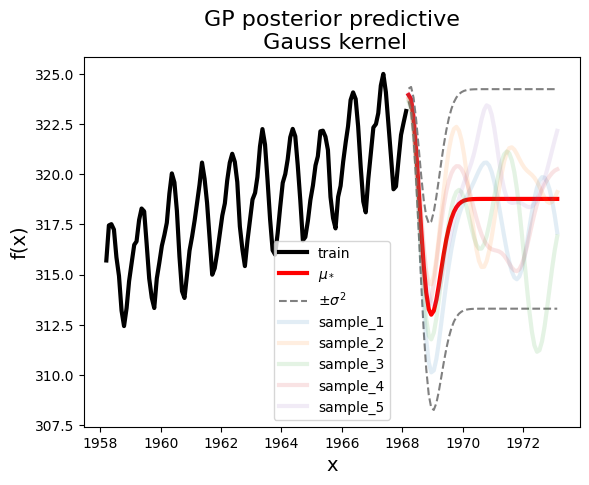

In [47]:
pred_mu_gauss, pred_cov_gauss = conditional(X[:, np.newaxis], X_predict[:, np.newaxis], y, 0.001, lambda x,y: ref_gaussian_kernel(x, y, gamma=2))
pred_var_gauss = np.diag(pred_cov_gauss)

# rescale 
t_adjust = 1958
pred_mu = pred_mu_gauss*y_std + y_mean
pred_var =pred_var_gauss*y_std**2

# sample posterior dist:
gp_gauss_post_samples = ss.multivariate_normal.rvs(mean=pred_mu_gauss, cov=pred_cov_gauss, size=5)


# visualize
plt.plot(X + t_adjust, y*y_std + y_mean, c="k", lw=3., label="train")
plt.plot(X_predict + t_adjust, pred_mu, c="r", lw=3., label=r"$\mu_*$")
plt.plot(X_predict + t_adjust, pred_mu+1.96*pred_var**0.5, color='grey', linestyle="dashed", label=r"$\pm \sigma^2$")
plt.plot(X_predict + t_adjust, pred_mu-1.96*pred_var**0.5, color='grey', linestyle="dashed")
for i, sample in enumerate(gp_gauss_post_samples):
    plt.plot(X_predict + t_adjust, sample*y_std + y_mean, lw=3., alpha=0.125, label=f"sample_{i+1}")
# plt.hlines(0, X[0], X_predict[-1], lw=3., colors="k", linestyles="dashed")
plt.ylabel("f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.legend()
plt.title("GP posterior predictive\n Gauss kernel", fontsize=16)
plt.show()